In [2]:
from CycleGAN import CycleGAN 
import numpy as np 
import matplotlib.pyplot as plt
import pylab as  pl 
from IPython.display import clear_output
from ResUnet import ResUNet , preprocess_data  , augment_dataset

In [3]:
BATCH_SIZE = 64
EPOCHS=250
workdir="/pscratch/sd/g/giuspugl/workstation/CO_network/extending_CO" 

In [4]:


model = CycleGAN( epochs= EPOCHS, enable_function=True , pretrained =True , 
                workdir =workdir  , sigma=0.1 ) 

2025-10-08 07:25:47.880382: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38366 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0


/pscratch/sd/g/giuspugl/workstation/CO_network/extending_CO/checkpoints/ckpt-43 Latest checkpoint restored!!


In [5]:
dust = np.load(f'{workdir}/COM_CompMap_Dust-GNILC-F857_2048_R2.00_15amin_training.npz')['patches'  ]
nh = np.log10(np.load(f'{workdir}/NHI_HI4Pi_16amin_nside2048_inpainted_training.npz')['patches']) 
co10 = np.load(f'{workdir}/CO10type2_15amin_nside2048_training.npz')['patches']
co21 = np.load(f'{workdir}/CO21type2_15amin_nside2048_training.npz')['patches']

In [6]:

Xin   = np.float32(np.stack([dust,nh ], axis=-1 ) ) 
#Xout = np.expand_dims(co ,axis=-1 )
Xout = np.float32(np.stack([co10,co21  ], axis=-1 )) 
masklongitudes = np.load(f'{workdir}/co_ext_longitudinal_splitmask.npy')

In [7]:
xtrain ,xval, xtest =  preprocess_data ( arr=Xin ,split_wo_overlap=True   , longitudemask = masklongitudes  )
ytrain ,yval, ytest =  preprocess_data ( arr=Xout  ,split_wo_overlap=True    , longitudemask =masklongitudes  , rescale=True   )
print(xtrain.shape,xval.shape ,xtest.shape)
xtrain = augment_dataset (xtrain)
xval = augment_dataset (xval )
ytrain = augment_dataset (ytrain)
yval = augment_dataset (yval )
xtest = augment_dataset (xtest )
ytest = augment_dataset (ytest )

print(xtrain.shape,xval.shape ,xtest.shape)

xtrain = np.vstack((xtrain,xval))# we don't need validation for GANs
ytrain = np.vstack((ytrain,yval))# we don't need validation for GANs
#np.savez(f'{workdir}/testset.npz',  xtest= xtest,ytest=ytest  )

(3496, 128, 128, 2) (372, 128, 128, 2) (249, 128, 128, 2)
(10488, 128, 128, 2) (1116, 128, 128, 2) (747, 128, 128, 2)


In [ ]:
model. train(BATCH_SIZE=BATCH_SIZE, 
                xtrain=xtrain,
                ytrain=ytrain ) 

2025-10-06 08:06:57.770885: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_12/sequential_103/dropout_12/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


..................Time taken for epoch 1 is 64.55468855402432 sec

Saving checkpoint for epoch 1 at /pscratch/sd/g/giuspugl/workstation/CO_network/extending_CO//checkpoints/ckpt-27
..................Time taken for epoch 2 is 36.380071494029835 sec

..................Time taken for epoch 3 is 36.355465300846845 sec

.......

In [8]:
model.predict(xtest, ytest) 
#model.save_predictions() 
"""
class model() : 
    def __init__(self,file):
        self.ypred = file['ypred'] 
        self.xpred = file['xpred'] 
    
model  = model (np.load(f'{workdir}/CO_fullsky_pred.npz') ) 
""" 



2025-10-08 07:26:30.078138: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8903


"\nclass model() : \n    def __init__(self,file):\n        self.ypred = file['ypred'] \n        self.xpred = file['xpred'] \n    \nmodel  = model (np.load(f'{workdir}/CO_fullsky_pred.npz') ) \n"

In [ ]:
model.save_predictions() 

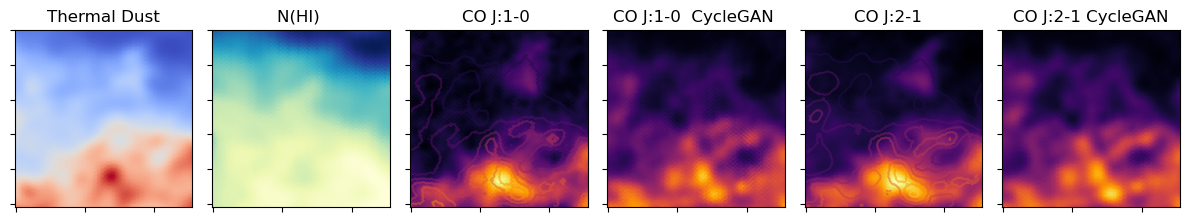

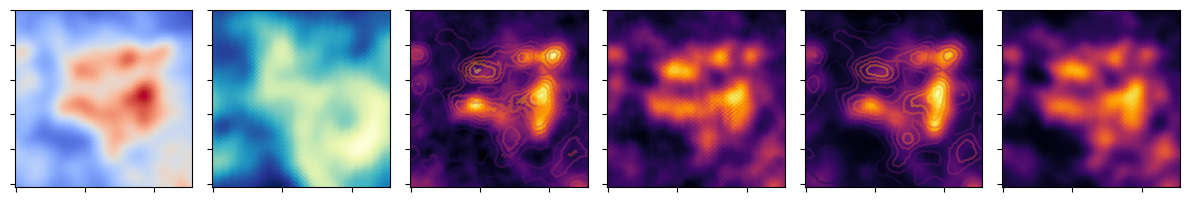

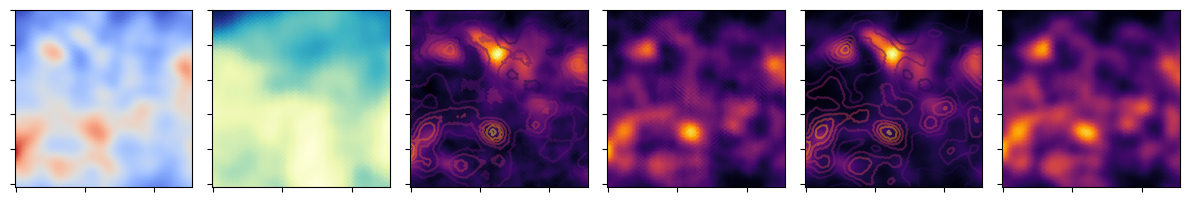

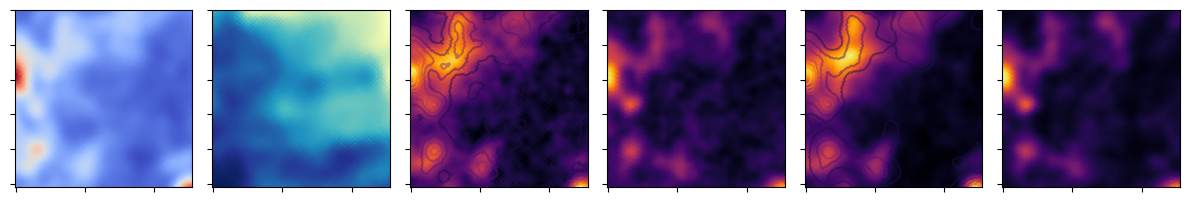

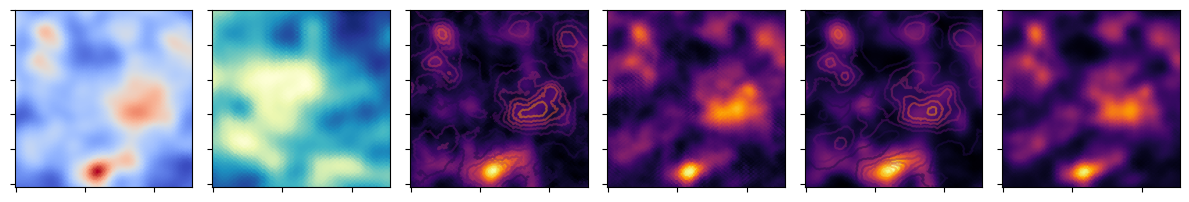

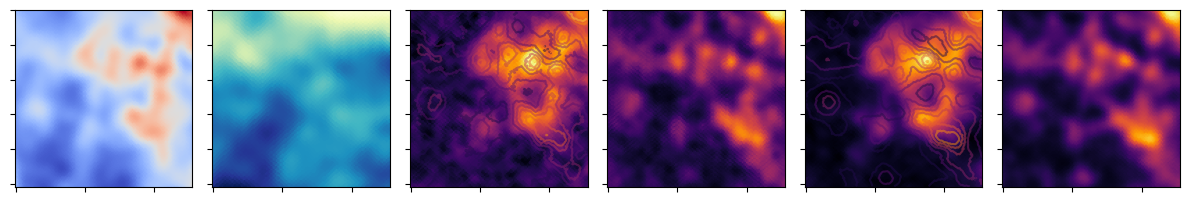

In [11]:
c=0 
Ntest= xtest.shape[0] 
np.random.seed(1234569876)
randint= np.random.randint(0,Ntest,6)
for jj, i in enumerate(randint) :
#for image_x, image_y in zip (xtest, ytest  ) : 
    
    image_x= np.expand_dims(xtest[i] ,axis=0 )      
    image_y= np.expand_dims(ytest[i] ,axis=0 )   
    pred_y = np.expand_dims(model.ypred[i],axis=0) #generate_images(generator_g, image_x[0]) #  Y=G(X) 
    pred_x = np.expand_dims(model.xpred[i],axis=0)
   
    pl.figure(figsize=(12,8))
    
    
    pl.subplot(161)
    if jj==0: pl.title('Thermal Dust')
    
    pl.imshow(image_x  [0,:,:,0]  #,cmap=pl.cm.inferno) 
             , vmin=-1,vmax=1 ,cmap=pl.cm.coolwarm);#pl.colorbar() 
    #pl.contour(pred_x  [0,:,:,0 ],cmap=pl.cm.coolwarm  , alpha=.5)
    pl.yticks(visible=False ) 
    pl.xticks(visible=False ) 
     
    pl.subplot(162 )
    if jj==0: pl.title('N(HI) ')
    
    pl.imshow(image_x  [0,:,:,1], cmap=pl.cm.YlGnBu_r, vmin=-1,vmax=1)
    #pl.colorbar() 
    #pl.imshow(hogco , cmap=plt.cm.gray_r,alpha=.5)
    pl.yticks(visible=False ) 
    pl.xticks(visible=False )     
    pl.subplot(163)
     
    if jj==0: pl.title('CO J:1-0 ')
    pl.imshow(image_y  [0,:,:,0] , cmap=pl.cm.inferno, vmin=-1,vmax=1)
    #pl.colorbar() 
    
    pl.contour(pred_y  [0,:,:,0 ],cmap=pl.cm.inferno , vmin=-1,vmax=1 , alpha=.5)
    #pl.imshow(hogco , cmap=plt.cm.gray_r,alpha=.5)
    pl.yticks(visible=False ) 
    pl.xticks(visible=False ) 
    pl.subplot(164)
    if jj==0: pl.title('CO J:1-0  CycleGAN ')
    #pl.imshow(cop[i], cmap=pl.cm.inferno, vmin =cotset [i].min(), vmax =cotset[i].max()  ) 
    pl.imshow(pred_y  [0,:,:,0 ], cmap=pl.cm.inferno, vmin=-1,vmax=1) 
              #, vmin =cot [i].min(), vmax =cot[i].max() )
    #pl.colorbar() 
    pl.yticks(visible=False ) 
    pl.xticks(visible=False ) 
    pl.subplot(165)
    if jj==0: pl.title('CO J:2-1  ')
    pl.imshow(image_y  [0,:,:,1] , cmap=pl.cm.inferno, vmin=-1,vmax=1)
    #pl.colorbar() 
    pl.contour(pred_y  [0,:,:,1 ],cmap=pl.cm.inferno  , alpha=.5)
    #pl.imshow(hogco , cmap=plt.cm.gray_r,alpha=.5)
    pl.yticks(visible=False ) 
    pl.xticks(visible=False ) 
    pl.subplot(166)
    if jj==0: pl.title('CO J:2-1 CycleGAN')
    #pl.imshow(cop[i], cmap=pl.cm.inferno, vmin =cotset [i].min(), vmax =cotset[i].max()  ) 
    pl.imshow(pred_y  [0,:,:,1 ], cmap=pl.cm.inferno, vmin=-1,vmax=1) 
              #, vmin =cot [i].min(), vmax =cot[i].max() )
    pl.yticks(visible=False ) 
    pl.xticks(visible=False ) 

    pl.tight_layout() 
    #pl.colorbar() 
    c+=1    
    #if c>0: break 
    pl.savefig(f'stacks_{jj}.pdf') 


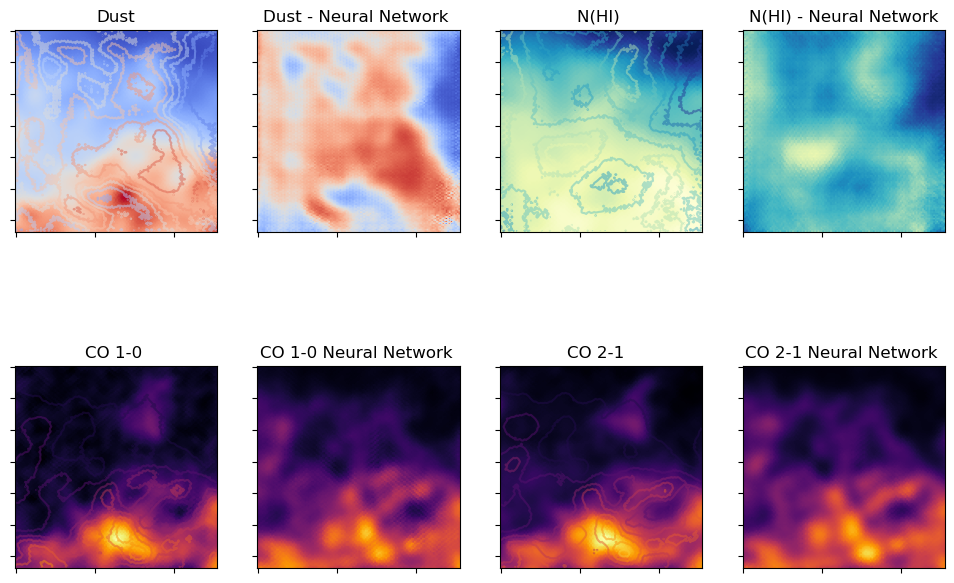

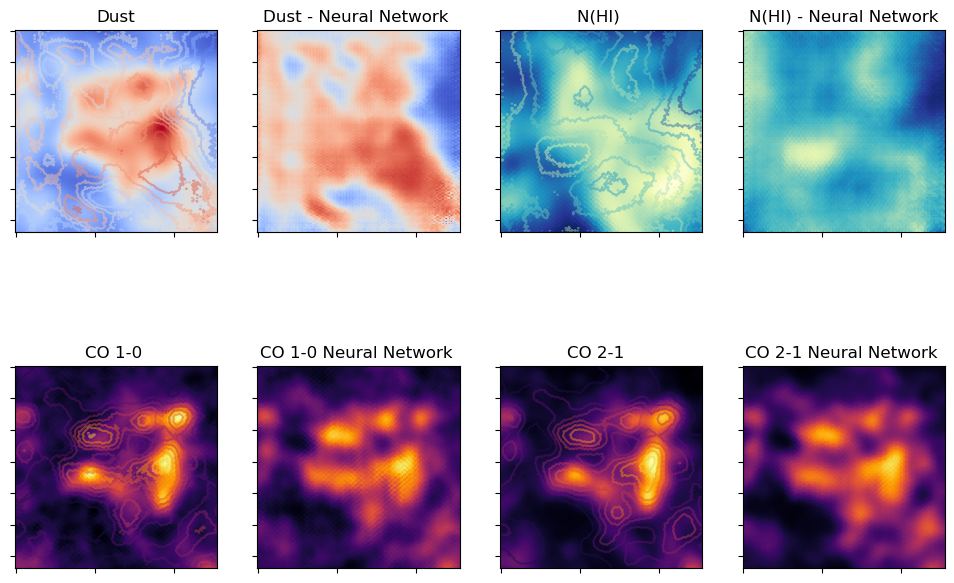

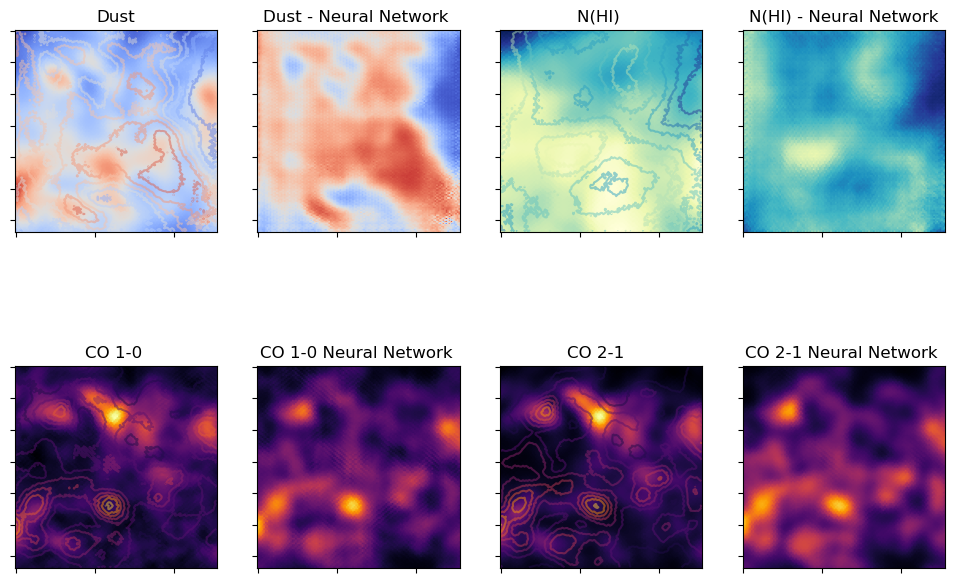

In [10]:
c=0 
Ntest= xtest.shape[0] 
np.random.seed(1234569876)
randint= np.random.randint(0,Ntest,3 )
for i in randint:
#for image_x, image_y in zip (xtest, ytest  ) : 
    
    image_x= np.expand_dims(xtest[i] ,axis=0 )      
    image_y= np.expand_dims(ytest[i] ,axis=0 )   
    pred_y = np.expand_dims(model.ypred[i],axis=0) #generate_images(generator_g, image_x[0]) #  Y=G(X) 
    pred_x = np.expand_dims(model.xpred[i],axis=0)
   
    pl.figure(figsize=(12,8))
    
    
    pl.subplot(241)
    pl.title('Dust')
    
    pl.imshow(image_x  [0,:,:,0]  #,cmap=pl.cm.inferno) 
             , vmin=-1,vmax=1 ,cmap=pl.cm.coolwarm);#pl.colorbar() 
    pl.contour(pred_x  [0,:,:,0 ],cmap=pl.cm.coolwarm  , alpha=.5)
    pl.yticks(visible=False ) 
    pl.xticks(visible=False ) 
    pl.subplot(242)
    pl.title('Dust - Neural Network ')
    
    pl.imshow(pred_x  [0,:,:,0]  #,cmap=pl.cm.inferno) 
              , vmin=-1,vmax=1,cmap=pl.cm.coolwarm);#pl.colorbar() 
    pl.yticks(visible=False ) 
    pl.xticks(visible=False )     
    #pl.imshow(hogco , cmap=plt.cm.gray_r,alpha=.5)
    pl.subplot(243)
    pl.title('N(HI) ')
    
    pl.imshow(image_x  [0,:,:,1], cmap=pl.cm.YlGnBu_r, vmin=-1,vmax=1)
    #pl.colorbar() 
    #pl.imshow(hogco , cmap=plt.cm.gray_r,alpha=.5)
    pl.yticks(visible=False ) 
    pl.xticks(visible=False )     
    pl.contour(pred_x  [0,:,:,1 ],cmap=pl.cm.YlGnBu_r , alpha=.5)
    pl.subplot(244)
    pl.title('N(HI) - Neural Network')
    
    pl.imshow(pred_x  [0,:,:,1], cmap=pl.cm.YlGnBu_r, vmin=-1,vmax=1)
    #pl.colorbar() 
    pl.yticks(visible=False ) 
    pl.xticks(visible=False )    
    pl.subplot(245)
    pl.title('CO 1-0 ')
    pl.imshow(image_y  [0,:,:,0] , cmap=pl.cm.inferno, vmin=-1,vmax=1)
    #pl.colorbar() 
    
    pl.contour(pred_y  [0,:,:,0 ],cmap=pl.cm.inferno , vmin=-1,vmax=1 , alpha=.5)
    #pl.imshow(hogco , cmap=plt.cm.gray_r,alpha=.5)
    pl.yticks(visible=False ) 
    pl.xticks(visible=False ) 
    pl.subplot(246)
    pl.title('CO 1-0 Neural Network ')
    #pl.imshow(cop[i], cmap=pl.cm.inferno, vmin =cotset [i].min(), vmax =cotset[i].max()  ) 
    pl.imshow(pred_y  [0,:,:,0 ], cmap=pl.cm.inferno, vmin=-1,vmax=1) 
              #, vmin =cot [i].min(), vmax =cot[i].max() )
    #pl.colorbar() 
    pl.yticks(visible=False ) 
    pl.xticks(visible=False ) 
    pl.subplot(247)
    pl.title('CO 2-1  ')
    pl.imshow(image_y  [0,:,:,1] , cmap=pl.cm.inferno, vmin=-1,vmax=1)
    #pl.colorbar() 
    pl.contour(pred_y  [0,:,:,1 ],cmap=pl.cm.inferno  , alpha=.5)
    #pl.imshow(hogco , cmap=plt.cm.gray_r,alpha=.5)
    pl.yticks(visible=False ) 
    pl.xticks(visible=False ) 
    pl.subplot(248)
    pl.title('CO 2-1 Neural Network ')
    #pl.imshow(cop[i], cmap=pl.cm.inferno, vmin =cotset [i].min(), vmax =cotset[i].max()  ) 
    pl.imshow(pred_y  [0,:,:,1 ], cmap=pl.cm.inferno, vmin=-1,vmax=1) 
              #, vmin =cot [i].min(), vmax =cot[i].max() )
    pl.yticks(visible=False ) 
    pl.xticks(visible=False ) 
    #pl.colorbar() 
    c+=1    
    #if c>0: break 


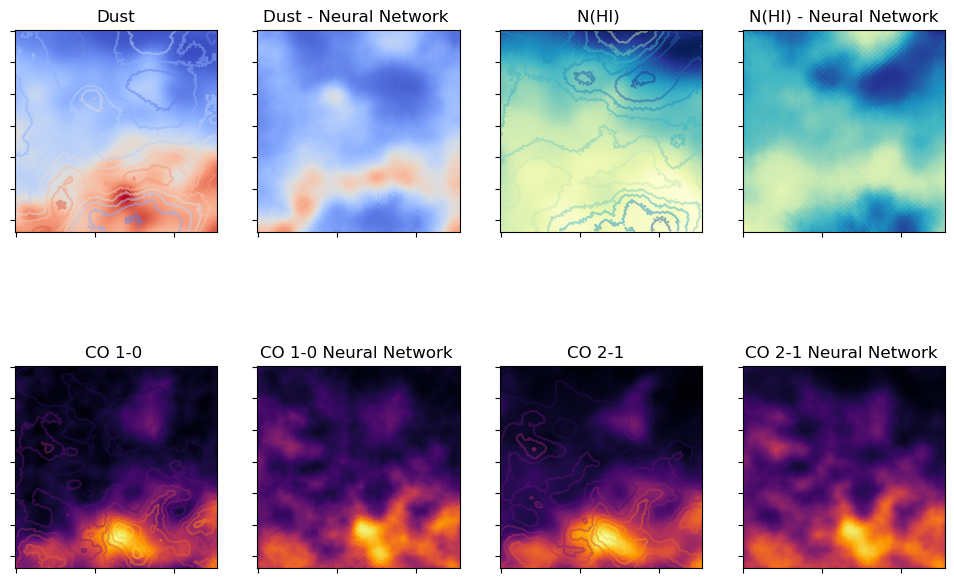

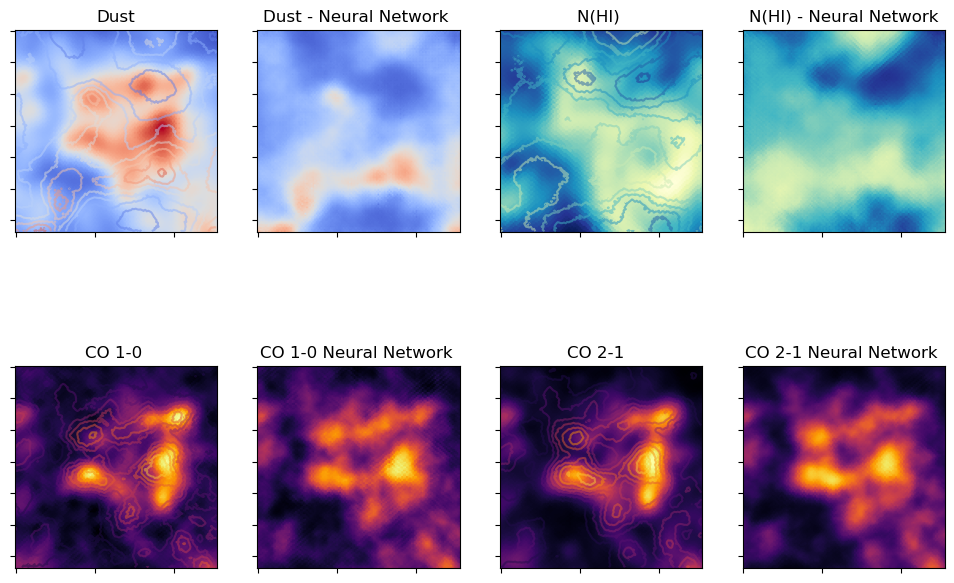

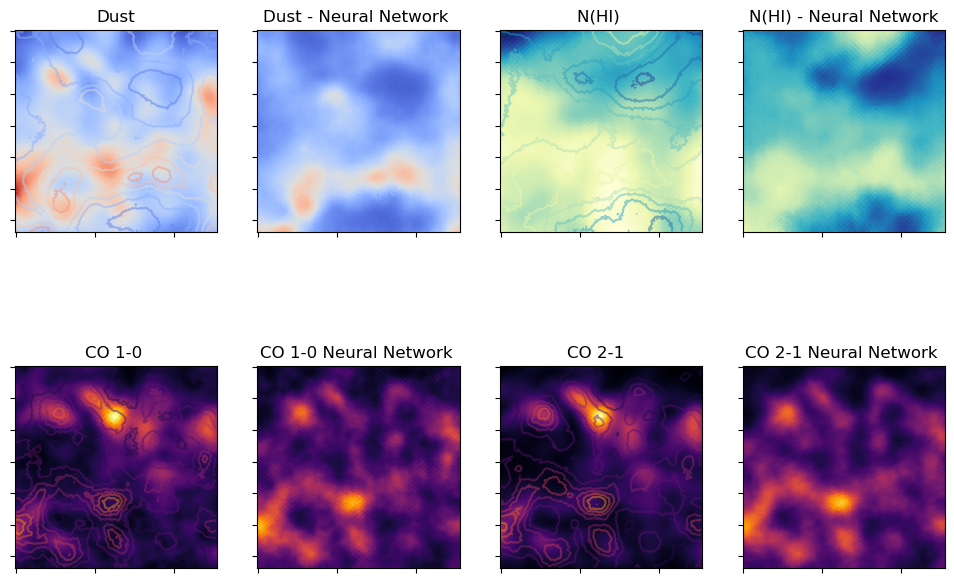

In [9]:
c=0 
Ntest= xtest.shape[0] 
np.random.seed(1234569876)
randint= np.random.randint(0,Ntest,3 )
for i in randint:
#for image_x, image_y in zip (xtest, ytest  ) : 
    
    image_x= np.expand_dims(xtest[i] ,axis=0 )      
    image_y= np.expand_dims(ytest[i] ,axis=0 )   
    pred_y = np.expand_dims(model.ypred[i],axis=0) #generate_images(generator_g, image_x[0]) #  Y=G(X) 
    pred_x = np.expand_dims(model.xpred[i],axis=0)
   
    pl.figure(figsize=(12,8))
    
    
    pl.subplot(241)
    pl.title('Dust')
    
    pl.imshow(image_x  [0,:,:,0]  #,cmap=pl.cm.inferno) 
             , vmin=-1,vmax=1 ,cmap=pl.cm.coolwarm);#pl.colorbar() 
    pl.contour(pred_x  [0,:,:,0 ],cmap=pl.cm.coolwarm  , alpha=.5)
    pl.yticks(visible=False ) 
    pl.xticks(visible=False ) 
    pl.subplot(242)
    pl.title('Dust - Neural Network ')
    
    pl.imshow(pred_x  [0,:,:,0]  #,cmap=pl.cm.inferno) 
              , vmin=-1,vmax=1,cmap=pl.cm.coolwarm);#pl.colorbar() 
    pl.yticks(visible=False ) 
    pl.xticks(visible=False )     
    #pl.imshow(hogco , cmap=plt.cm.gray_r,alpha=.5)
    pl.subplot(243)
    pl.title('N(HI) ')
    
    pl.imshow(image_x  [0,:,:,1], cmap=pl.cm.YlGnBu_r, vmin=-1,vmax=1)
    #pl.colorbar() 
    #pl.imshow(hogco , cmap=plt.cm.gray_r,alpha=.5)
    pl.yticks(visible=False ) 
    pl.xticks(visible=False )     
    pl.contour(pred_x  [0,:,:,1 ],cmap=pl.cm.YlGnBu_r , alpha=.5)
    pl.subplot(244)
    pl.title('N(HI) - Neural Network')
    
    pl.imshow(pred_x  [0,:,:,1], cmap=pl.cm.YlGnBu_r, vmin=-1,vmax=1)
    #pl.colorbar() 
    pl.yticks(visible=False ) 
    pl.xticks(visible=False )    
    pl.subplot(245)
    pl.title('CO 1-0 ')
    pl.imshow(image_y  [0,:,:,0] , cmap=pl.cm.inferno, vmin=-1,vmax=1)
    #pl.colorbar() 
    
    pl.contour(pred_y  [0,:,:,0 ],cmap=pl.cm.inferno , vmin=-1,vmax=1 , alpha=.5)
    #pl.imshow(hogco , cmap=plt.cm.gray_r,alpha=.5)
    pl.yticks(visible=False ) 
    pl.xticks(visible=False ) 
    pl.subplot(246)
    pl.title('CO 1-0 Neural Network ')
    #pl.imshow(cop[i], cmap=pl.cm.inferno, vmin =cotset [i].min(), vmax =cotset[i].max()  ) 
    pl.imshow(pred_y  [0,:,:,0 ], cmap=pl.cm.inferno, vmin=-1,vmax=1) 
              #, vmin =cot [i].min(), vmax =cot[i].max() )
    #pl.colorbar() 
    pl.yticks(visible=False ) 
    pl.xticks(visible=False ) 
    pl.subplot(247)
    pl.title('CO 2-1  ')
    pl.imshow(image_y  [0,:,:,1] , cmap=pl.cm.inferno, vmin=-1,vmax=1)
    #pl.colorbar() 
    pl.contour(pred_y  [0,:,:,1 ],cmap=pl.cm.inferno  , alpha=.5)
    #pl.imshow(hogco , cmap=plt.cm.gray_r,alpha=.5)
    pl.yticks(visible=False ) 
    pl.xticks(visible=False ) 
    pl.subplot(248)
    pl.title('CO 2-1 Neural Network ')
    #pl.imshow(cop[i], cmap=pl.cm.inferno, vmin =cotset [i].min(), vmax =cotset[i].max()  ) 
    pl.imshow(pred_y  [0,:,:,1 ], cmap=pl.cm.inferno, vmin=-1,vmax=1) 
              #, vmin =cot [i].min(), vmax =cot[i].max() )
    pl.yticks(visible=False ) 
    pl.xticks(visible=False ) 
    #pl.colorbar() 
    c+=1    
    #if c>0: break 


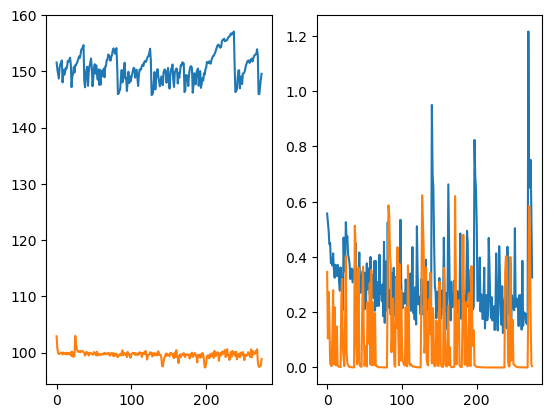

In [12]:

L = np.load('extending_CO/losses_2025102_63129.npz') 
L2 = np.load('extending_CO/losses_2025102_6116.npz')
pl.subplot(121) 

pl.plot(np.hstack([L['losses_g'] , L2['losses_g']  ]))#[::50] ) 
pl.plot(np.hstack([L['losses_f'] , L2['losses_f']  ]) )#[::50]) 
pl.subplot(122) 
pl.plot(np.hstack([L['losses_discx'] , L2['losses_discx']  ]))#[::50] ) 
pl.plot(np.hstack([L['losses_discy'] , L2['losses_discy']  ]))#[::50] ) 

#pl.plot(L['losses_f'] ) 
#pl.plot(L['losses_discx'] ) 
#pl.plot(L['losses_discy'] ) 

#pl.plot(L['losses_g'] ) 
#pl.plot(L['losses_f'] ) 
#pl.plot(L['losses_discx'] ) 
#pl.plot(L['losses_discy'] ) 

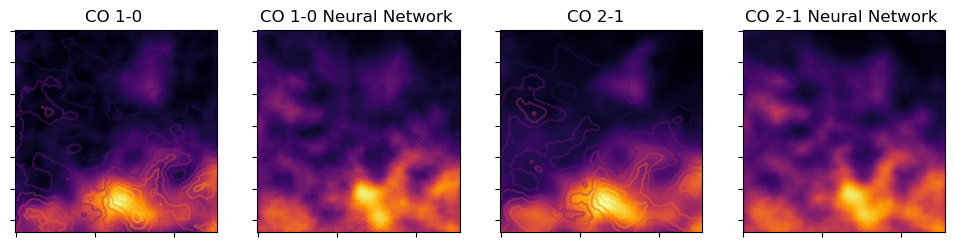

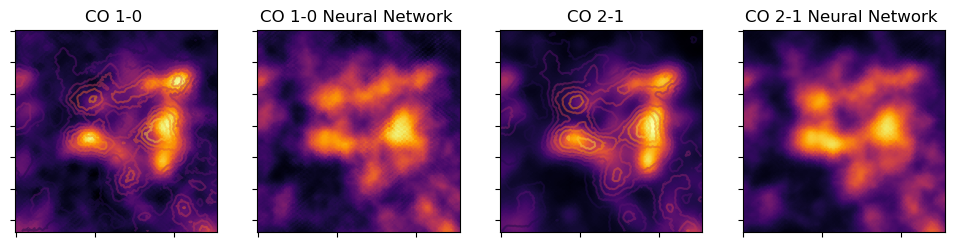

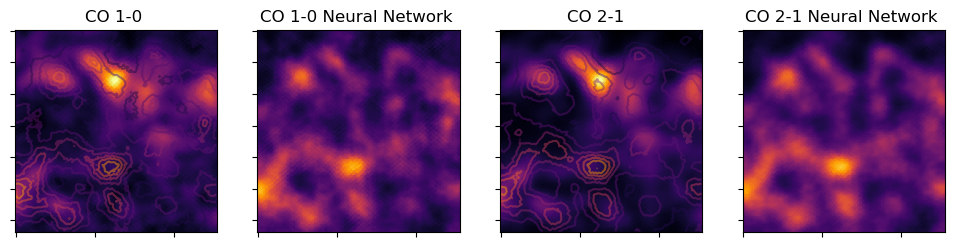

In [10]:
c=0 
Ntest= xtest.shape[0] 
np.random.seed(1234569876)
randint= np.random.randint(0,Ntest,3 )
for i in randint:
#for image_x, image_y in zip (xtest, ytest  ) : 
    
    image_x= np.expand_dims(xtest[i] ,axis=0 )      
    image_y= np.expand_dims(ytest[i] ,axis=0 )   
    pred_y = np.expand_dims(model.ypred[i],axis=0) #generate_images(generator_g, image_x[0]) #  Y=G(X) 
    pred_x = np.expand_dims(model.xpred[i],axis=0)
   
    pl.figure(figsize=(12,8))
    
    pl.subplot(141)
    pl.title('CO 1-0 ')
    pl.imshow(image_y  [0,:,:,0] , cmap=pl.cm.inferno, vmin=-1,vmax=1)
    #pl.colorbar() 
    
    pl.contour(pred_y  [0,:,:,0 ],cmap=pl.cm.inferno , vmin=-1,vmax=1 , alpha=.5)
    #pl.imshow(hogco , cmap=plt.cm.gray_r,alpha=.5)
    pl.yticks(visible=False ) 
    pl.xticks(visible=False ) 
    pl.subplot(142)
    pl.title('CO 1-0 Neural Network ')
    #pl.imshow(cop[i], cmap=pl.cm.inferno, vmin =cotset [i].min(), vmax =cotset[i].max()  ) 
    pl.imshow(pred_y  [0,:,:,0 ], cmap=pl.cm.inferno, vmin=-1,vmax=1) 
              #, vmin =cot [i].min(), vmax =cot[i].max() )
    #pl.colorbar() 
    pl.yticks(visible=False ) 
    pl.xticks(visible=False ) 
    pl.subplot(143)
    pl.title('CO 2-1  ')
    pl.imshow(image_y  [0,:,:,1] , cmap=pl.cm.inferno, vmin=-1,vmax=1)
    #pl.colorbar() 
    pl.contour(pred_y  [0,:,:,1 ],cmap=pl.cm.inferno  , alpha=.5)
    #pl.imshow(hogco , cmap=plt.cm.gray_r,alpha=.5)
    pl.yticks(visible=False ) 
    pl.xticks(visible=False ) 
    pl.subplot(144)
    pl.title('CO 2-1 Neural Network ')
    #pl.imshow(cop[i], cmap=pl.cm.inferno, vmin =cotset [i].min(), vmax =cotset[i].max()  ) 
    pl.imshow(pred_y  [0,:,:,1 ], cmap=pl.cm.inferno, vmin=-1,vmax=1) 
              #, vmin =cot [i].min(), vmax =cot[i].max() )
    pl.yticks(visible=False ) 
    pl.xticks(visible=False ) 
    #pl.colorbar() 
    c+=1    
    #if c>0: break 


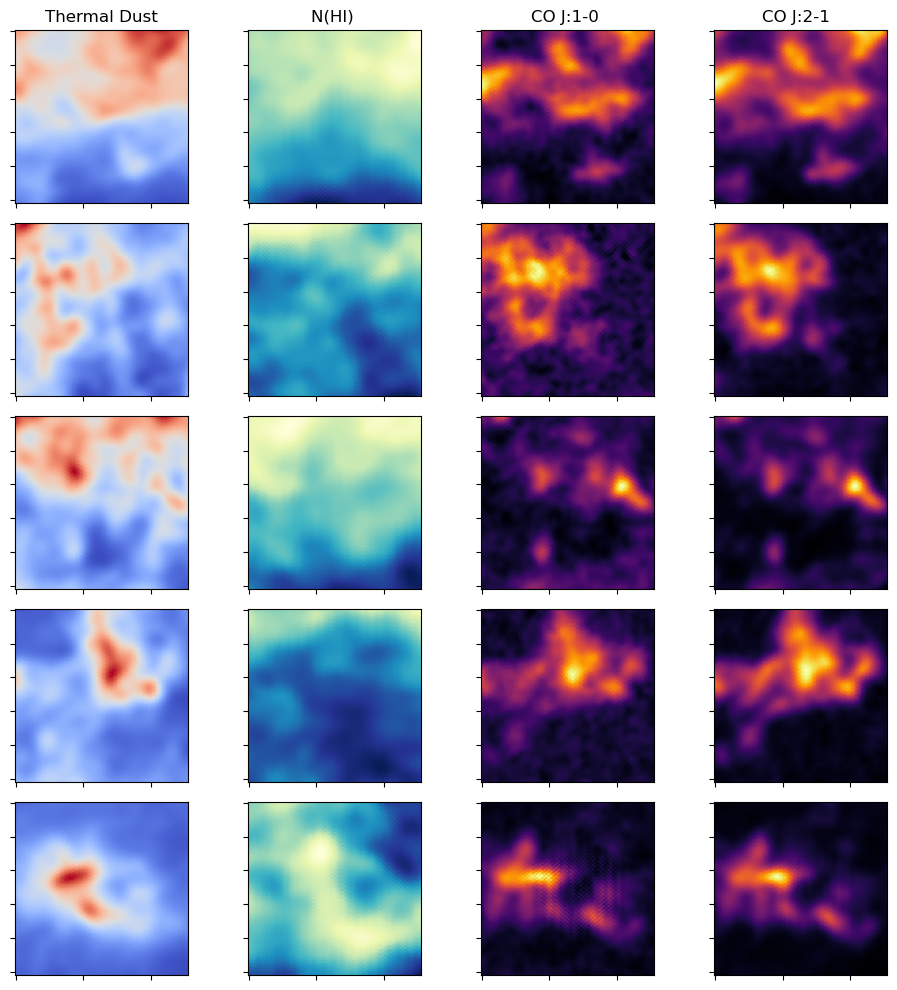

In [11]:
c=0 
Ntest= xtest.shape[0] 
np.random.seed(123456987)
randint= np.random.randint(0,Ntest,6 )
pl.figure(figsize=(10,10))

for jj,i in enumerate(randint) :
#for image_x, image_y in zip (xtest, ytest  ) : 
    
    image_x= np.expand_dims(xtest[i] ,axis=0 )      
    image_y= np.expand_dims(ytest[i] ,axis=0 )   
    #pred_y = np.expand_dims(model.ypred[i],axis=0) #generate_images(generator_g, image_x[0]) #  Y=G(X) 
    #pred_x = np.expand_dims(model.xpred[i],axis=0)
    if jj==3:
        continue    
    if jj>=3:
        jj-=1

        
    
    pl.subplot(5,4,1+jj*4)
    if jj==0: pl.title('Thermal Dust')
    
    pl.imshow(image_x  [0,:,:,0]  #,cmap=pl.cm.inferno) 
             , vmin=-1,vmax=1 ,cmap=pl.cm.coolwarm);#pl.colorbar() 
    pl.yticks(visible=False ) 
    pl.xticks(visible=False ) 
    pl.subplot(5,4,2+jj*4) 
    if jj==0:pl.title('N(HI) ')
    
    pl.imshow(image_x  [0,:,:,1], cmap=pl.cm.YlGnBu_r, vmin=-1,vmax=1)
    #pl.colorbar() 
    #pl.imshow(hogco , cmap=plt.cm.gray_r,alpha=.5)
    pl.yticks(visible=False ) 
    pl.xticks(visible=False )     
    pl.subplot(5,4,3+jj*4)
    if jj==0:pl.title('CO J:1-0 ')
    pl.imshow(image_y  [0,:,:,0] , cmap=pl.cm.inferno, vmin=-1,vmax=1)
    #pl.colorbar() 
    
    #pl.imshow(hogco , cmap=plt.cm.gray_r,alpha=.5)
    pl.yticks(visible=False ) 
    pl.xticks(visible=False ) 
    pl.subplot(5,4,4+jj*4) 
   
    if jj==0:pl.title('CO J:2-1  ')
    pl.imshow(image_y  [0,:,:,1] , cmap=pl.cm.inferno, vmin=-1,vmax=1)
    #pl.colorbar() 
    #pl.imshow(hogco , cmap=plt.cm.gray_r,alpha=.5)
    pl.yticks(visible=False ) 
    pl.xticks(visible=False   ) 
    #pl.grid(True, alpha=.5 ) 
    #break 
    pl.tight_layout() 
pl.savefig('input_tiles.pdf') 